# Assessing Stability of Unsupervised Clusterings

Dylan Rogerson  
June 24th, 2016

In data analysis we often use unsupervised clustering methods to allow us to assess the structure of unlabeled data. Here at Activision, an easy example would be to use one of these methods to characterize our players. A highly engaged player who's been with us for years has a different concept of the game from a newer player who just picked up a controller for the first time. When we sift through our data we might expect to see groups of more and less experienced players, calling these players 'Hardcore' and 'Newbie', adding perhaps a third category for 'Midcore' (players that have played a bit, but aren't Hardcore). But what does the data actually tell us? What groups naturally arise out of the data itself? Which variables should we consider and how do these variables define our groups? These are all areas where machine learning and unsupervised clustering methods in particular can help out.

The topic today assumes you have a working knowledge around unsupervised methods. In particular we will focus on K-means clustering, a popular method in the space. As such there are few a properties that we would like our final segmentation to have:

1) We want our work to be reproducible in the same dataset. While different distance metrics and clustering methods may lead to different interpretations of the data, we at least strive to get the same interpretations for the same method in the same dataset.

2) We want to pick a 'good' number of clusters, k. Traditionally we pick k from an information theory or explained varience approach where our goal is to have a clustering that does a good job of explaining the dataset (https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). We'll see that we can further improve our determination of k by picking a clustering that is also stable.

3) We want our segments to be interpretable and actionable. This in a way limits our number of clusters. Too many segments and we lose our ability to interpret the clusters and therefore create an effective action plan. Too few and we might risk generalizing our audience, creating a simplistic treatment and missing the opportunity for a more tailored and effective approach.

Most of the work done here focuses on reseach from 'Clustering Stability: An Overview' by Luxburg 2010 (http://arxiv.org/abs/1007.1075). This paper is definitely worth a read through and gives a strong background on the sources of instability and what others are doing in the field to address it.

There's a lot to digest here so let's start with a dataset (https://www.kaggle.com/census/2013-american-community-survey). The linked dataset is the 2013 American Community Survey which contains a great wealth of information: a combination of tax data and surveys about house electronics. 

Today let's focus on the wealth distribution of Americans. We would like to see how much people work and where their earning comes from (including investing or other sources of income). Additionally, we expect this behavior to be different for different age groups and levels of education. Let's throw all of this together to see if can find identifiable groups. 

### The Dataset

In [2]:
setwd("D:/Work Directory")


#install.packages("flexclust",repos="http://cran.stat.ucla.edu/")

#Turn Off Warnings
options(warn=-1)

# Visualize Correlations
library(corrplot)
# Speed up hclust
library(fastcluster)
# For Heatmaps.2
library(gplots)
# Plotting Library
library(ggplot2)
# Library to Color our Heatmaps
library(RColorBrewer)
# Package for Determining Cutoff for Cluster Size Based on Fit to Data
library(GMD)
#For scoring K-means on a new Dataset
library(flexclust)


#Turn On Warnings
options(warn=0)

# Creating a palette for Heatmaps
mypalette <- brewer.pal(10,"RdBu")

# Our Survey Data
datacs <- read.csv("./GAS Presentation/ss13pusa.csv")

In [5]:
datprep1 <- datacs[datacs$AGEP>=21,c("WAGP","WKHP","SCHL","OIP","INTP","AGEP","SEX","pwgtp1","pwgtp2")]

datprep1[is.na(datprep1)] <- 0

# Only include people who made money from wages or interest/dividends
datprep1a <- (datprep1[datprep1$WAGP > 0 & datprep1$INTP >= 0,])

print("Total Number of Rows in Our Dataset")
nrow(datprep1a)
print("First 6 Rows in Our Dataset")
head(datprep1a)
print("Summary of Our Dataset")
summary(datprep1a)

[1] "Total Number of Rows in Our Dataset"


[1] 707659

[1] "First 6 Rows in Our Dataset"


,WAGP,WKHP,SCHL,OIP,INTP,AGEP,SEX,pwgtp1,pwgtp2
2,52000,40,20,0,0,55,2,45,51
6,39000,40,21,0,0,63,2,481,575
12,90000,48,16,0,0,59,1,83,58
13,46000,40,18,0,0,56,2,69,49
17,20000,25,21,0,0,72,1,60,163
18,28000,40,19,0,0,52,2,29,91


[1] "Summary of Our Dataset"


      WAGP             WKHP            SCHL           OIP         
 Min.   :     4   Min.   : 1.00   Min.   : 1.0   Min.   :    0.0  
 1st Qu.: 16000   1st Qu.:36.00   1st Qu.:16.0   1st Qu.:    0.0  
 Median : 34000   Median :40.00   Median :19.0   Median :    0.0  
 Mean   : 47441   Mean   :39.03   Mean   :18.6   Mean   :  404.2  
 3rd Qu.: 60000   3rd Qu.:43.00   3rd Qu.:21.0   3rd Qu.:    0.0  
 Max.   :660000   Max.   :99.00   Max.   :24.0   Max.   :83000.0  
      INTP             AGEP            SEX            pwgtp1      
 Min.   :     0   Min.   :21.00   Min.   :1.000   Min.   : -28.0  
 1st Qu.:     0   1st Qu.:32.00   1st Qu.:1.000   1st Qu.:  36.0  
 Median :     0   Median :44.00   Median :1.000   Median :  75.0  
 Mean   :  1465   Mean   :44.22   Mean   :1.484   Mean   : 103.3  
 3rd Qu.:     0   3rd Qu.:55.00   3rd Qu.:2.000   3rd Qu.: 131.0  
 Max.   :300000   Max.   :95.00   Max.   :2.000   Max.   :2494.0  
     pwgtp2      
 Min.   :  -8.0  
 1st Qu.:  36.0  
 Median 

Again, today we're going to focus on the wealth distribution on Americans. We'll segment people based off of the following attributes and see what the data tells us. We're also focused more on the stability methodology, so if you like to clean your data differently or use a different clustering method, go for it!

The variables used in clustering:

WAGP = Wages in the past 12 Months  
WKHP = Working Hours Per Week  
SCHL = Educational Attainment (Basically your level of education - non-linear)  
OIP  = All other income past 12 months  
INTP = Interest, dividends and net rental income past 12 months  
AGEP = Age  

Other variables worth mentioning:

SEX  = 1 Male 2 Female  
pwgtp1 = A weight replicate  
pwgtp2 = A different weight replicate  

While most of the variables seem straightforward, we should cover weight replicates. They're included in the survey because the people surveyed are not represented equally across the general population. By including these weights in measurements (such as weighted averages). You can get a more accurate picture. For the sake of simplicity, today we're going to ignore this field, but if you want to calculate individual metrics, you should take this variable into account.

Secondly, when we started our investigation we included sex, however there didn't seem to be a drastic change in the interpretation of groups when sex was introduced. Effectively, we ended up just splitting existing groups by gender. Since this variable increased the number of segments without adding any new interpretation or information, we decided to drop this variable.

We also wanted to look at working adults (or those earning interest) and concentrated on people of at least 21 years of age. 

Our final dataset includes 707k people.

### Our Method for Today

For our approach today we'll focus on using a popular unsupervised clustering method, K-means. Even though this method is widely used for it's robustness and versitility. There are several assumptions that are relevant to K-means as well as drawbacks (clusters tend to be equally sized and the distribution of clusters is assumed to be spherical to name a few). For a more detailed discussion of the assumptions that go into the method feel free to check out http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means.

Working with our dataset. We'll follow these steps:

1) First we scale the data set (subtract the mean and divide by the standard deviation for each variables) in order to evenly weight each variable. K-Means can also be sensitive to outliers (since it's concerned with means instead of medians) and so we also curb outliers in the data set to an absolute maximum of 2 standard deviations. In other words, if the absolute value of the datapoint is over 2, we set it to 2. Notice that we also create a train and holdout dataset. In the future we'll want to compare how different clusterings perform on the same dataset.

2) Run the resulting data through PCA, cutting out the last loading and leaving 93% of the varience. This helps reduce overweighting of variables in a highly correlated dataset. Since there is not a high degree of correlation in our variables this will not have a strong effect, however it has become a standard procedure that has many side benefits we've come to appreciate. Additionally, like K, there is debate as to what makes a 'good' cutoff and how many loadings explain enough of the varience in the data. Cutoffs in the range of 80-90% are common in the space.

3) Since we're using K-means we need to pick K. We can perform a clustering methodology or test to find a starting value for the number of clusters. There are a variety of methods to employ here (as mentioned above and in https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) though we'll constrain ourselves to evaluating a dendrogram from a hierarchical clustering of the dataset.

4) Seed K-means. The typical implementation of the K-means algorithm selects the initial centers randomly from the dataset. There are stronger methods for initalizing K-means to more accurately cover the space of the data and converge to the global minimum in the dataset quickly. Such methods are outlined in Bubeck 2009 (http://www.jmlr.org/papers/volume10/bubeck09a/bubeck09a.pdf) and Dasgupta and Schulman 2007 (http://dl.acm.org/citation.cfm?id=1248666) and simplified in Luxburg 2010.

5) Finally we'll use this seed to initialize K-means on a subsample of our training dataset.

In [6]:
#Prep the Full Dataset

datprep2<-datprep1a[,1:6]
datprep4 <- apply(datprep2,2,scale)

#Curb Outliers
datprep4[datprep4>2]<-2
datprep4[datprep4<(-2)]<-(-2)

#Perform PCA

pcadat<-prcomp(datprep4,
               center = TRUE,
               scale. = TRUE)

print("Summary of the PCA Components of Our Dataset")
summary(pcadat)

#Cut off the last loading
datprep5<-pcadat$x
datprep6<-datprep5[,1:(ncol(datprep5)-1)]

randomSample<-runif(nrow(datprep1a))

holdout<-datprep6[randomSample>=0.9,] #Holdout for Cluster Label Comparision (Rand Index)
train<-datprep6[randomSample<0.9,] #Data to Train the Clustering Models on

trainRaw<-datprep2[randomSample<0.9,]

[1] "Summary of the PCA Components of Our Dataset"


Importance of components:
                          PC1    PC2    PC3    PC4    PC5     PC6
Standard deviation     1.3162 1.0554 0.9965 0.9682 0.8981 0.64545
Proportion of Variance 0.2887 0.1856 0.1655 0.1562 0.1344 0.06943
Cumulative Proportion  0.2887 0.4744 0.6399 0.7961 0.9306 1.00000

### Determining The Number of Clusters From a Dendrogram

As an aside I'd like to address how to interpret a Hierarchical Clustering Dendrogram. This is one of many ways (similar to the Elbow Plot method) to determine the number of clusters and there is some art to it.

First a dendrogram shows where our splits occur in our dataset as we increase the number of clusters. The vertical height denotes how much error we incur when we say that every datapoint is actually its closest centroid or the intercluster dissimilarity. In this way it's similar to an Elbow Plot. We're looking for the biggest change in error (in this case in height) that will meaningfully describe the data.

[1] "A Visualization of Our Hierarchical Clustering Dendogram"


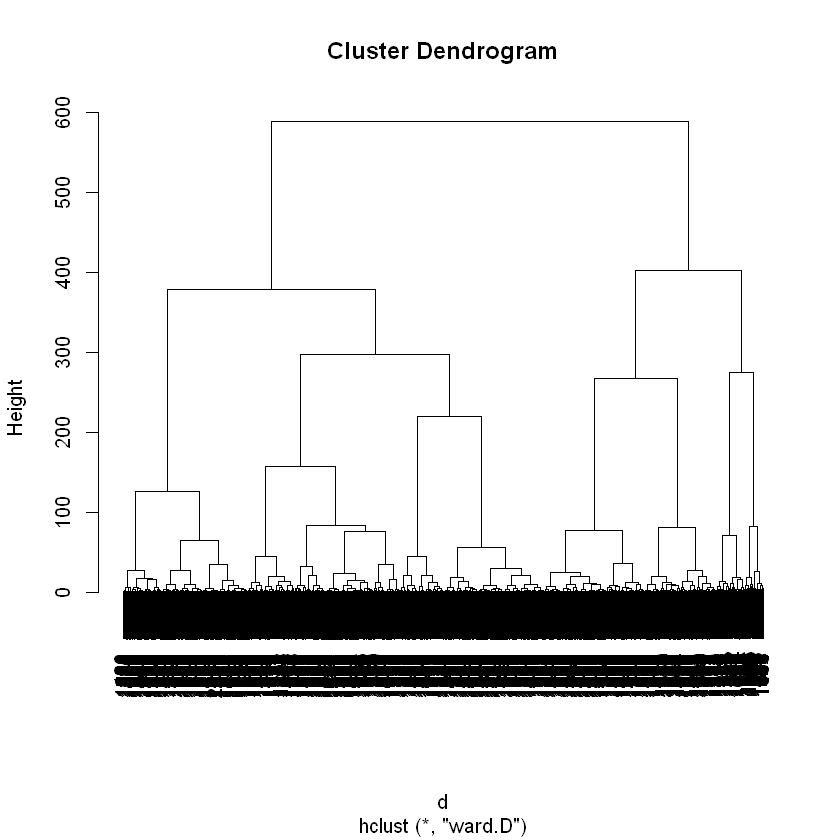

In [79]:
# Perform Hclust on a 2k sample
samp <- datprep6[sample(1:nrow(datprep6),2000),]
d <- dist(samp, method = "euclidean")
fit <- hclust(d, method = "ward.D") 

print("A Visualization of Our Hierarchical Clustering Dendogram")
plot(fit)

ksize <- 4 #Define size of the cluster
groups <- cutree(fit, k = ksize)
centroids <- aggregate(samp, by = list(groups), FUN = mean)

Looking top to bottom we see that the split to 2 clusters causes a very big drop in error and the next biggest splits occurs at 4 (3 is a pretty negligable difference). So 4 clusters seems like a good start.

### The Initialization Method

In point 4 of 'A Clustering Method' we mentioned the R implementation of K-means initializes off of random points in the dataset. The largest issue here is that of coverage, and outliers. Are we picking points that cover the full space of the data without ignoring outliers? A robust initialization scheme for this issue can be found in Dasgupta and Schulman (2007) / Bubeck (2009) and is best described for K-means in Luxburg (2010).

We'll initialize with the following procedure (copied directly from Luxburg (2010):

1) Select L preliminary centers uniformly at random from the given data set, where L ≈ K log(K).  

2) Run one step of K-means, that is assign the data points to the preliminary centers and re-adjust the centers once.  

3) Remove all centers for which the mass of the assigned data points is smaller than p0 = 1/(2 L). In Luxburg, they quote approximately 1/L, however we've found 1/(2 L) works quite well. Additionally, is this doesn't give us greater than K clusters to choose from, we simply initialize with the K largest clusters.  

4) Among the remaining centers, select K centers by the following procedure:  
    a) Choose the first center uniformly at random.  
    b) Repeat until K centers are selected: Select the next center as the one that maximizes the minimum distance to the centers already selected.  

The code block below executes the above steps and outputs our initial centers.

In [7]:
#Turn Off Warnings
options(warn=-1)

ksize <- 4

  ##Initialization Method For Kmeans Described in Dasgupta and Schulman (2007)
  
  initialKmeans <- kmeans(datprep6, ceiling(ksize*log(ksize)),iter.max = 1)
  validCenters <- initialKmeans$size/nrow(datprep6)*ceiling(ksize*log(ksize)) > 1/2
  centersNoOutliers <- initialKmeans$centers[validCenters,]
  
  
if (sum(validCenters) > ksize) {
  
  nextCenter <- centersNoOutliers[1,] #Start with a Random Center
  initialCenters <- data.frame(t(nextCenter))
  centersConsidered <- 2:nrow(centersNoOutliers) #Keep track of the centers that can still be added
  
  for(i in 1:(ksize-1)){
    
    k2<-matrix(,ncol = nrow(centersNoOutliers),nrow = i)
    
    for(k in 1:i) {
    
    for( j in 1:nrow(centersNoOutliers)) {
      k2[k,j]<-sum((centersNoOutliers[j,]-initialCenters[k,])^2)
       }
    } #Create a Distance Matrix between the centers currently selected and all centers
    
    if(i == 1){
      k3 <- k2}else{
    clusterWithMaxMinDistance <- which.max(apply(k2[,centersConsidered],1,FUN=min))
    k3 <- k2[clusterWithMaxMinDistance,]
    } #Calculating relevant distances to find the cluster that maximizes the minimum distance to the centers already selected.
  
    nextCenter <- centersNoOutliers[centersConsidered[which.max( k3[centersConsidered])],] 
      #Select the center which maximizes the minimum distance to one of the centers already selected
    centersConsidered <- centersConsidered[-which.max( k3[centersConsidered])]
      #One selected we have to remove it from the centers that are still up for selection
    initialCenters <- rbind(initialCenters,nextCenter)
      #And finally add the new center to the list of initialization centers for K-means.
    
  }
  
}else {initialCenters <- centersNoOutliers }

### Running our First K-Means Clustering

Now that we have our inital centers we can run K-means. Let's also save our initial clustering (called 'initialSegmentation') in the code so we can compare it to other clusterings that we run.

In [9]:

#Run K means on the whole dataset

PCAKmeans <- kmeans(datprep6, initialCenters)
clustersize <- PCAKmeans$size/sum(PCAKmeans$size)*100
initialSegmentation <- aggregate(datprep4,by = list(PCAKmeans$cluster),FUN = mean)
initialSegmentation <- initialSegmentation[,2:ncol(initialSegmentation)]

print("Our First Attempt at Clustering")
print("Segment Mean Values")
data.frame(round(aggregate(datprep2,by = list(PCAKmeans$cluster),FUN = mean),2),clustersize)

#Turn On Warnings
options(warn=0)

[1] "Our First Attempt at Clustering"
[1] "Segment Mean Values"


,Group.1,WAGP,WKHP,SCHL,OIP,INTP,AGEP,clustersize
1,1,25599.97,36.35,18.68,32.49,83.06,30.49,35.23773
2,2,100249.4,47.24,20.86,17.02,4278,48.6,28.11425
3,3,32766.6,37.73,18.59,10064.16,1175.44,45.13,3.758307
4,4,27376.87,35.04,16.6,29.7,574.26,55.07,32.88971


### Results

So what did we get back from all of this? We see 4 segments.

Group 1 - Our Young Workforce: Not just the youngest segment, but the one with the least amount of investing and other sources of income. Many of these people may be part-time and still in college.

Group 2 - High Education / Work Week: This group is comprised of professionals with a good deal of experience in age and education (and a moderate amount of income from other sources.

Group 3 - Other Sources of Income: This very small group (3.8%) relies on other sources of income as well as a standard wage. While similar in age to the High Education group, they have slightly less education.

Group 4 - Low Education / Work Week: This group is comprised of older individuals with lower schooling and income.

But as we'll see, they're not perfectly stable.

### Stability Testing

So we're done right? We picked our cutoff by looking at a dendogram (hey it looks like 4 clusters will work fine) and maybe we even run this whole thing a few times on different datasets to make sure we see the same kind of clusters. Unfortunately this isn't the whole story. We can easily decieve ourselves into thinking we have a stable result and unsupervised clustering methods have a particularly nasty habit of 'jumping around' under different samples of data (more on that later). Running this clustering several times may produce different results. In fact let's do just that.

In this method we're comparing each subsequent segmentation to our initial segmentation (first run). How often subsequent clusterings agree will dictate whether we're happy with current clustering methodology. To say it another way, if we get different clusters every time, our work isn't reproducible.

Here we sample 100,000 points from our training dataset and go through the same steps we mentioned in sections 'The Initial Segmentation Method', 'Running our First K-mean Clustering Method' and 'Results' 10 times. The first time we save our result as the 'initialSegmentation'. We then compare the next 9 iterations (or runs) to the initial segmentation.

Every time we perform a new run we determine our labels from scratch. That is to say that cluster 1 from our initial segmentation may be 'Low Education / Work Week' and cluster 1 from our second run may be 'Our Young Workforce'. In order to make sure that cluster 1 is always talking about 'Low Education / Work Week', we compare each clusters in run 2 to the initial one and assign labels based on the minimum euclidean distance between each cluster (ignoring the clusters we've already assigned). For instance we might find that cluster 3 in run 2 is very close to cluster 1 from our intial run, and therefore our best guess for 'Low Education / Work Week'. We then reassign cluster 3 in run 2 as cluster 1 and move through the rest of the clusters in run 2 reassigning as necessary. You can see the code for this in the section "Reorder Labels to Match First Clustering" below.

Once all of these clusters have been relabeled we will have the minimum cluster to cluster distance between these segmentations. Dividing by the number of clusters gives us the 'Mean Cluster to Cluster Distance' reported in the output. If this number is large then our new segmentation is quite dissimilar from our inital segmentation.

While this is a helpful measurement of cluster dissimilarity a far more robust measure of cluster dissimilarity is the Rand Index (refered to in Luxberg 2010). We'll report this too and after we see some results we'll go into a bit more depth on exactly what the Rand Index is and how to interpret our findings.

For brevity we'll suppress the code, but feel free to expand it.

In [106]:
#Turn Off Warnings
options(warn=-1)

ksize<-4
bootstraps<-10

assignmentResults<-data.frame(matrix(,nrow = bootstraps, ncol = 1000))
randResults<-c()


for (iclustering in 1:bootstraps) {
  
  
  samplingIntegers<-sample(1:nrow(train),100000)
  
  datprep7<-train[samplingIntegers,]
  datprepRaw<-trainRaw[samplingIntegers,]
  
  ##Initialization Method For Kmeans Described in Dasgupta and Schulman (2007)
  
  initialKmeans <- kmeans(datprep7, ceiling(ksize*log(ksize)),iter.max = 1)
  validCenters <- initialKmeans$size/nrow(datprep7)*ceiling(ksize*log(ksize)) > 1/2
  centersNoOutliers <- initialKmeans$centers[validCenters,]
  
  
if (sum(validCenters) > ksize) {
  
  nextCenter <- centersNoOutliers[1,] #Start with a Random Center
  initialCenters <- data.frame(t(nextCenter))
  centersConsidered <- 2:nrow(centersNoOutliers) #Keep track of the centers that can still be added
  
  for(i in 1:(ksize-1)){
    
    k2<-matrix(,ncol = nrow(centersNoOutliers),nrow = i)
    
    for(k in 1:i) {
    
    for( j in 1:nrow(centersNoOutliers)) {
      k2[k,j]<-sum((centersNoOutliers[j,]-initialCenters[k,])^2)
       }
    } #Create a Distance Matrix between the centers currently selected and all centers
    
    if(i == 1){
      k3 <- k2}else{
    clusterWithMaxMinDistance <- which.max(apply(k2[,centersConsidered],1,FUN=min))
    k3 <- k2[clusterWithMaxMinDistance,]
    } #Calculating relevant distances to find the cluster that maximizes the minimum distance to the centers already selected.
  
    nextCenter <- centersNoOutliers[centersConsidered[which.max( k3[centersConsidered])],] 
      #Select the center which maximizes the minimum distance to one of the centers already selected
    centersConsidered <- centersConsidered[-which.max( k3[centersConsidered])]
      #One selected we have to remove it from the centers that are still up for selection
    initialCenters <- rbind(initialCenters,nextCenter)
      #And finally add the new center to the list of initialization centers for K-means.
    
  }
  
}else {initialCenters <- centersNoOutliers }
  
  
  
  #Now we do Kmeans
  
  PCAKmeans <- kcca(datprep7, k = as.matrix(initialCenters), kccaFamily("kmeans"),simple=TRUE)
  
  
  clustersize<-PCAKmeans@clusinfo$size/sum(PCAKmeans@clusinfo$size)
  testcluster<-aggregate(datprep7,by=list(PCAKmeans@cluster),FUN = mean)
  testcluster<-testcluster[,2:ncol(testcluster)]
  testClusterRealValues <- aggregate(datprepRaw,by=list(PCAKmeans@cluster),FUN = mean)
  
  
  #Reorder Labels to Match First Clustering
  if(iclustering==1) {
    truecluster<-testcluster
    initialSegmentation<-PCAKmeans
  } else {
    
    clustersconsidered<-1:ksize
    clusterscore2<- 1:ksize
    cluster2clusterdistance<-0
    
    
    for ( i in 1:nrow(truecluster)) {
      
      
      k2<-c()
      for( j in 1:nrow(testcluster)) {
        k2[j]<-sum((testcluster[j,]-truecluster[i,])^2)
        
      }
      clusterscore2[i]<-clustersconsidered[which.min( k2[clustersconsidered])]
      cluster2clusterdistance<-cluster2clusterdistance + min( k2[clustersconsidered])
      clustersconsidered<-clustersconsidered[-which.min(k2[clustersconsidered])]
      
    }
  } 
  
  #If the first run create a table
  
  if (iclustering==1) {
    output<-testcluster
    output$segment<-1:ksize
    output$run<-iclustering
 
    outputraw <-   testClusterRealValues[,2:ncol(testClusterRealValues)]
    outputraw$segment<-1:ksize
    outputraw$run<-iclustering
    
    #Labeling the holdout dataset with the model and using it to calculate the Rand Index
    labelsInitial<-predict(initialSegmentation,holdout)
    assignmentResults[iclustering,]<-labelsInitial[1:1000]
    randResults[iclustering] <- 1
    
    print( paste(c("Run                                   : ",iclustering),collapse=" " ))
    print( "" )
    
    
  } else {
      
  #If any other run append to the table
      
    new<-testcluster[clusterscore2,]
    new$segment<-1:ksize
    new$run<-iclustering
    output<-rbind(output,new)

    rawCenters<-testClusterRealValues[clusterscore2,]
    rawCenters$segment<-1:ksize
    rawCenters$run<-iclustering
    outputraw<-rbind(outputraw,rawCenters[,2:ncol(rawCenters)])
    
    #Labeling the holdout dataset with the model and using it to calculate the Rand Index  
    labelsTest<-predict(PCAKmeans,holdout)
    labelsTest2<-factor(labelsTest)
    levels(labelsTest2)<-order(clusterscore2)
    stabilityMeasure<-randIndex(labelsInitial[1:1000],labelsTest2[1:1000])
    assignmentResults[iclustering,]<-labelsTest2[1:1000]
    randResults[iclustering] <- stabilityMeasure
    
    
    print( paste(c("Run                                   : ",iclustering),collapse=" " ))
    print( paste(c("Rand Index (Cluster Similarity)       : ",stabilityMeasure),collapse=" " ))
    print( paste(c("Mean Cluster to Cluster Distance      : ",cluster2clusterdistance/ksize),collapse=" " ))
    print( "" )
    
    
  }
}

#Turn On Warnings
options(warn=0)

[1] "Run                                   :  1"
[1] ""
[1] "Run                                   :  2"
[1] "Rand Index (Cluster Similarity)       :  0.232962984867752"
[1] "Mean Cluster to Cluster Distance      :  14.6535690777866"
[1] ""
[1] "Run                                   :  3"
[1] "Rand Index (Cluster Similarity)       :  0.987185074113396"
[1] "Mean Cluster to Cluster Distance      :  0.00103289705216875"
[1] ""
[1] "Run                                   :  4"
[1] "Rand Index (Cluster Similarity)       :  0.98453419862814"
[1] "Mean Cluster to Cluster Distance      :  0.00206193074501161"
[1] ""
[1] "Run                                   :  5"
[1] "Rand Index (Cluster Similarity)       :  0.543519018344705"
[1] "Mean Cluster to Cluster Distance      :  7.71738488093683"
[1] ""
[1] "Run                                   :  6"
[1] "Rand Index (Cluster Similarity)       :  0.987864916938343"
[1] "Mean Cluster to Cluster Distance      :  0.00119873728593507"
[1] ""
[1] "Run   

So now we have several runs of our segmentation on different samples of the dataset and we found that the majority of the time we get 'similar segments'. What do I mean by 'similar'?

First, let's look at two runs that have small cluster to cluster distance. In the tables below we shows the clusters for our initial segmentation and run 3. We see that the two tables are quite similar if we compare each cell. We can also visualize this table with a heatmap, coloring high values with Blue and low with Red. Looking at values this way, Run 3 and the Initial Segmentation have very similar patterns and are nearly identical. 

[1] "Our Initial Segmentation"


,WAGP,WKHP,SCHL,OIP,INTP,AGEP
1,27611.72,35.08066,16.58214,31.03547,513.4261,55.20372
2,32600.02,37.7873,18.60336,10074.61,1199.137,44.77075
3,25622.85,36.4214,18.65289,31.73979,76.9764,30.57355
4,100713.3,47.1395,20.89377,16.80845,4397.971,48.54713


[1] "Our Results from Run 3"


,WAGP,WKHP,SCHL,OIP,INTP,AGEP
22,27596.09,35.31116,16.56168,30.99711,466.5372,54.98646
42,31676.05,37.71996,18.58777,10071.87,859.7223,45.38584
32,25373.68,36.17056,18.70392,31.06117,92.61854,30.48965
12,101711.6,47.28349,20.87861,18.18128,4488.324,48.43956


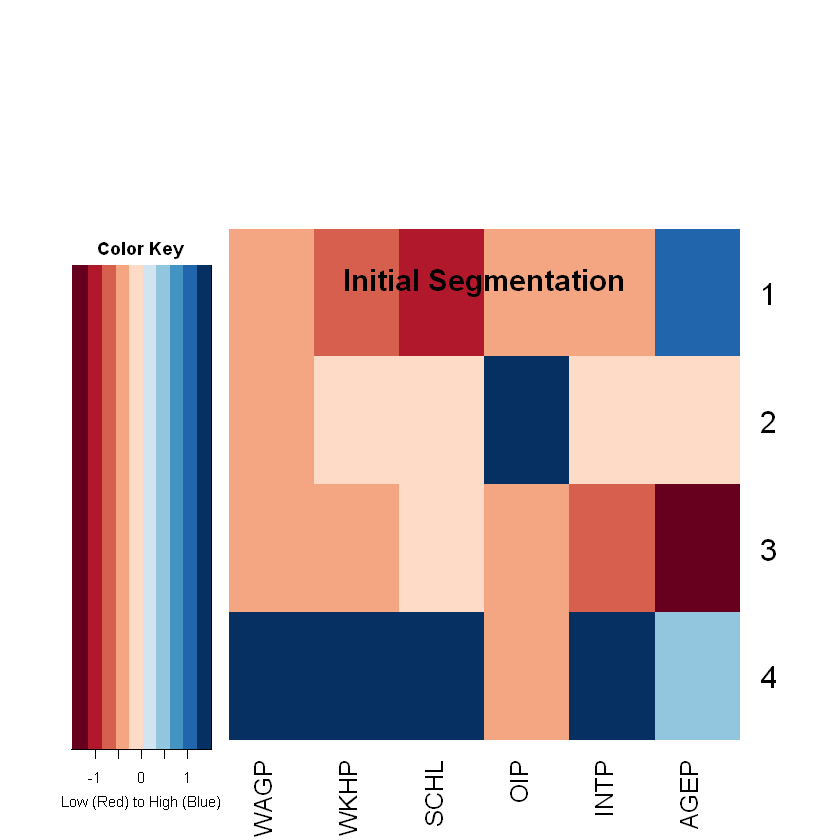

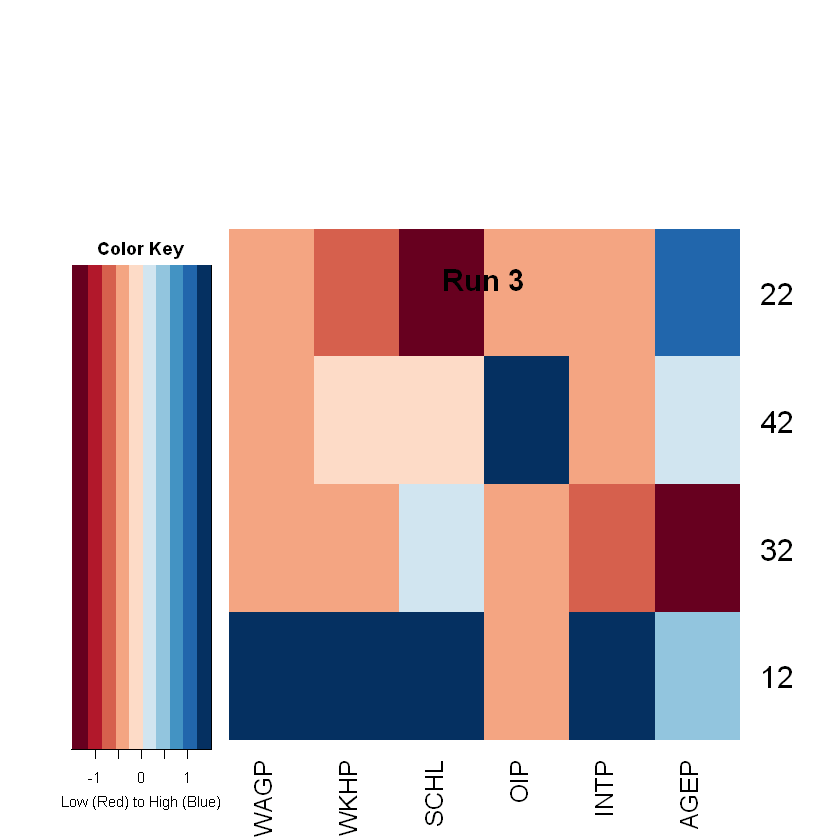

In [108]:

#Print Results
print("Our Initial Segmentation")
outputraw[outputraw$run == 1,1:(ncol(outputraw)-2)]
print("Our Results from Run 3")
outputraw[outputraw$run == 3,1:(ncol(outputraw)-2)]

#Plot Results
plot1<-heatmap.2(as.matrix(outputraw[outputraw$run == 1,1:(ncol(outputraw)-2)]),scale = "column",notecol = "black",Rowv = "False",Colv = "False"
                 ,main = "Initial Segmentation",col = mypalette,key.xlab = "Low (Red) to High (Blue)", trace = "none",density.info = "none")
plot2<-heatmap.2(as.matrix(outputraw[outputraw$run == 3,1:(ncol(outputraw)-2)]),scale = "column",notecol="black",Rowv="False",Colv="False"
                 ,main = "Run 3",col = mypalette,key.xlab = "Low (Red) to High (Blue)",trace = "none",density.info = "none")

We can also look at the raw difference between these clusterings. The largest difference is in WKHP (Working Hours Per Week) in segment 2 at 2% of the standard deviation of WKHP.

In [109]:
#Normalizing the Variables
m <- colMeans(datprep2)
sd <- apply(datprep2,2,FUN = sd)
M <- t(matrix(m))[rep(1,ksize),]
S <- t(matrix(sd))[rep(1,ksize),]

#Computing the difference
(outputraw[outputraw$run == 1,1:(ncol(outputraw)-2)]-M)/S - (outputraw[outputraw$run == 3,1:(ncol(outputraw)-2)]-M)/S

,WAGP,WKHP,SCHL,OIP,INTP,AGEP
1,0.0002763829,-0.01866915,0.006070284,1.392182e-05,0.003407244,0.01573137
2,0.01634655,0.005454563,0.00462637,0.0009949407,0.02466403,-0.04453691
3,0.004408337,0.02031592,-0.01514522,0.0002462934,-0.001136657,0.006074798
4,-0.01766085,-0.0116624,0.004498052,-0.0004982402,-0.00656564,0.007789398


### Measuring Cluster Similarity: Rand Index

You may have noticed in the output that cluster similarity was measured in two ways. The first is a simple calculation of cluster to cluster distance between centroids. A more robust method often used to compare clusterings is the Rand Index (https://en.wikipedia.org/wiki/Rand_index). For the Rand Index we compare how often two clusterings agree on the labels assigned to a datapoints in the cluster. Now, normally we would have a problem since cluster 1 in run 1 may not be the same are cluster 1 in run 2, but you'll recall that we reordered our labels using minimum distance in order to match our initial segmentation. In Luxburg 2010 the Rand Index is typically the maximum taken over ALL permutations of the index, but we'll use our short cut for now so we don't have to permute over all K.

As for properties of the Rand Index, if two clusterings completely agree on labels then the Rand Index is 1. If the clusterings complete disagree the Rand Index will be 0. In reality Rand Index should never drop below 0.5 since this value of a clustering compared against completely random labels.

We use the holdout set defined earlier in 'Our Method for Today' (point 1) in order to evaluate the Rand Index. 

Let's look at some examples. Here we see segmentations agree when we have a low cluster to cluster (Euclidean) distance and a high Rand Index: 

[1] "Run                                   :  3"  
[1] "Rand Index (Cluster Similarity)       :  0.987185074113396"  
[1] "Mean Cluster to Cluster Distance      :  0.00103289705216875"  

Conversely, we can also look at a segmentation that is completely different from what we started with. Here we see that not only is the Rand Index low, but the distance between our Initial Segmentation and our new run is massive.

[1] "Run                                   :  5"  
[1] "Rand Index (Cluster Similarity)       :  0.543519018344705"  
[1] "Mean Cluster to Cluster Distance      :  7.71738488093683"     

Let's visualize this as we did previously:

[1] "Our Initial Segmentation"


,WAGP,WKHP,SCHL,OIP,INTP,AGEP
1,27611.71635,35.08066,16.58214,31.03547,513.42614,55.20372
2,32600.01628,37.78730,18.60336,10074.60662,1199.13728,44.77075
3,25622.85121,36.42140,18.65289,31.73979,76.97640,30.57355
4,100713.31362,47.13950,20.89377,16.80845,4397.97057,48.54713


[1] "Our Results from Run 5"


,WAGP,WKHP,SCHL,OIP,INTP,AGEP
24,32316.34217,41.43658,15.70461,1044.78360,170.26842,51.12773
14,32005.57642,40.55994,19.19728,50.62555,60.22878,31.12786
34,11501.81730,18.91315,18.81042,396.90925,1413.28470,47.54802
44,104423.95262,46.59078,20.99859,131.00067,4751.29578,50.64040


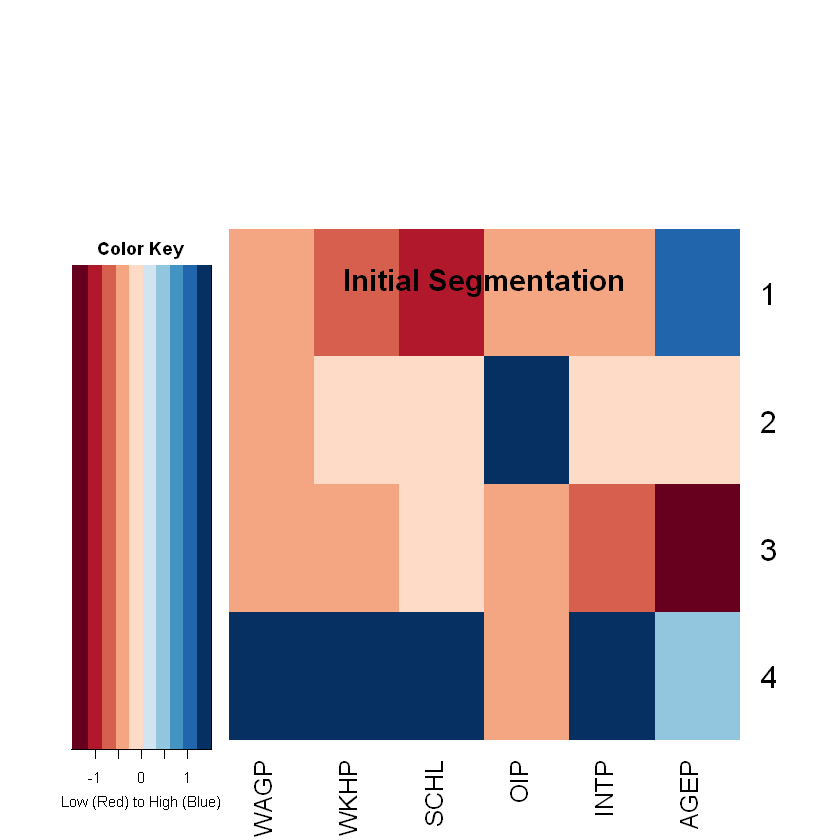

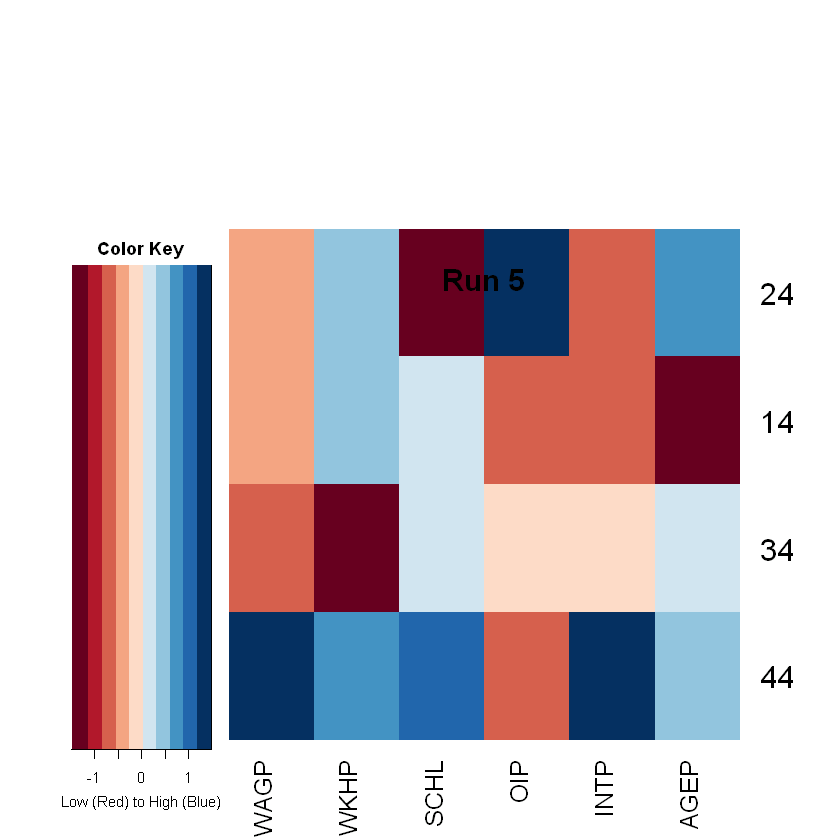

In [110]:
print("Our Initial Segmentation")
as.matrix(outputraw[outputraw$run==1,1:(ncol(outputraw)-2)])
print("Our Results from Run 5")
as.matrix(outputraw[outputraw$run==5,1:(ncol(outputraw)-2)])

heatmap.2(as.matrix(outputraw[outputraw$run==1,1:(ncol(outputraw)-2)]),scale = "column",notecol = "black",Rowv = "False",Colv = "False"
                 ,main = "Initial Segmentation",col = mypalette,key.xlab = "Low (Red) to High (Blue)", trace = "none",density.info = "none")

heatmap.2(as.matrix(outputraw[outputraw$run==5,1:(ncol(outputraw)-2)]),scale = "column",notecol="black",Rowv="False",Colv="False"
                 ,main = "Run 5",col = mypalette,key.xlab = "Low (Red) to High (Blue)",trace = "none",density.info = "none")


To highlight the differences, let's again look at the difference between the initial segmentation and run 5:

In [111]:
(outputraw[outputraw$run == 1,1:(ncol(outputraw)-2)]-M)/S - (outputraw[outputraw$run == 5,1:(ncol(outputraw)-2)]-M)/S

,WAGP,WKHP,SCHL,OIP,INTP,AGEP
1,-0.08323318,-0.5147928,0.2604136,-0.3679191,0.024936,0.295132
2,0.0105167,-0.2245678,-0.1762496,3.637999,0.08276025,0.987848
3,0.2498262,1.418066,-0.04674824,-0.1325308,-0.09710456,-1.229079
4,-0.06564779,0.04444289,-0.03110575,-0.04144373,-0.02567483,-0.1515682


So now we're looking at a completely different segmentation. We see that Run 4 has very different attributes for WKHP, OIP and AGEP compared to the initial clustering especially in clusters 2 and 3. We can say that when see a particularly high cluster to cluster distance or low Rand Index between clusterings we end up with a different interpretation of the data. This is what we wish to avoid. Let's look at this in another way.

### Visualizing Error

We have 10 Runs of Segmentation (Plus our Initial Segmentation). Let's plot the values for WAGP for every segmentation. What we'll see below is the value of WAGP for every 4 segments in our 10 runs. The first segment is colored red. Over 10 runs we see that there's a small amount of variation in WAGP for segments 1 and 4. In segment 3 (teal) however we see two vastly different values for WAGP in certain runs (under 15k and over 70k in runs 2 and 5 respectively), diverging from what we would normally expect (25k).

If we weren't looking at multiple runs we would never see this and might assume we'd always get the same clustering! Additionally this suggests that perhaps four clusters is not the best way to express this data...

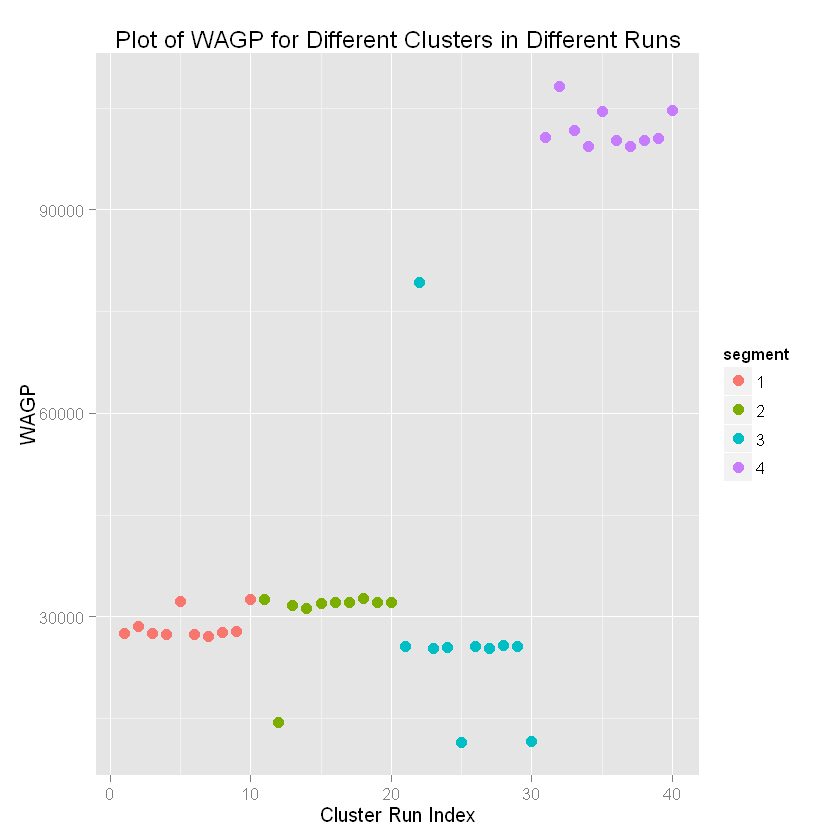

In [112]:
output2<-outputraw[order(outputraw$segment),]
output2$segment <- as.factor(output2$segment)
output2$index<-1:nrow(output2)

ggplot(output2, aes(x = index, y = WAGP, colour = segment)) + xlab("Cluster Run Index") + 
  geom_point(size = 3) + ggtitle("Plot of WAGP for Different Clusters in Different Runs") 

### What Does Stability Look Like?

With the methods above as a framework we can step through different clustering sizes and see if we arrive at more stable segmentations. We can also assess stability by using the mean Rand Index for each run (excluding the first). In our code we express this as 'randResults'. Unfortunately an old problem rears its ugly here. In this method we started with an initial segmentation (run 1) to compare to each subsequent segmentation. In a stable regime we're more than likely to land on the 'stable' segmentation on our first time, but this is always not the case. When we land on a bad segment we will need to reinitialize and try again. Hoping our first segmentation is a good one.

Suffice to say, there are better methods for getting around problems of initialization (discussed in detail in page 9 of Luxburg 2010). For now we'll leave that to a future blog post and say that working through this dataset we found that a segmentation with 9 clusters is quite stable.

Below we'll run the same code as in our 'Stability Testing' section, however we'll increase our number of clusters (K) to 9.

In [114]:
#Turn Off Warnings
options(warn=-1)

ksize<-9
bootstraps<-10

assignmentResults<-data.frame(matrix(,nrow = bootstraps, ncol = 1000))
randResults<-c()


for (iclustering in 1:bootstraps) {
  
  
  samplingIntegers<-sample(1:nrow(train),100000)
  
  datprep7<-train[samplingIntegers,]
  datprepRaw<-trainRaw[samplingIntegers,]
  
  ##Initialization Method For Kmeans Described in Dasgupta and Schulman (2007)
  
  initialKmeans <- kmeans(datprep7, ceiling(ksize*log(ksize)),iter.max = 1)
  validCenters <- initialKmeans$size/nrow(datprep7)*ceiling(ksize*log(ksize)) > 1/2
  centersNoOutliers <- initialKmeans$centers[validCenters,]
  
  
if (sum(validCenters) > ksize) {
  
  nextCenter <- centersNoOutliers[1,] #Start with a Random Center
  initialCenters <- data.frame(t(nextCenter))
  centersConsidered <- 2:nrow(centersNoOutliers) #Keep track of the centers that can still be added
  
  for(i in 1:(ksize-1)){
    
    k2<-matrix(,ncol = nrow(centersNoOutliers),nrow = i)
    
    for(k in 1:i) {
    
    for( j in 1:nrow(centersNoOutliers)) {
      k2[k,j]<-sum((centersNoOutliers[j,]-initialCenters[k,])^2)
       }
    } #Create a Distance Matrix between the centers currently selected and all centers
    
    if(i == 1){
      k3 <- k2}else{
    clusterWithMaxMinDistance <- which.max(apply(k2[,centersConsidered],1,FUN=min))
    k3 <- k2[clusterWithMaxMinDistance,]
    } #Calculating relevant distances to find the cluster that maximizes the minimum distance to the centers already selected.
  
    nextCenter <- centersNoOutliers[centersConsidered[which.max( k3[centersConsidered])],] 
      #Select the center which maximizes the minimum distance to one of the centers already selected
    centersConsidered <- centersConsidered[-which.max( k3[centersConsidered])]
      #One selected we have to remove it from the centers that are still up for selection
    initialCenters <- rbind(initialCenters,nextCenter)
      #And finally add the new center to the list of initialization centers for K-means.
    
  }
  
}else {initialCenters <- centersNoOutliers }
  
  
  
  
  #Now we do Kmeans
  
  PCAKmeans <- kcca(datprep7, k = as.matrix(initialCenters), kccaFamily("kmeans"),simple=TRUE)
  
  
  clustersize<-PCAKmeans@clusinfo$size/sum(PCAKmeans@clusinfo$size)
  testcluster<-aggregate(datprep7,by=list(PCAKmeans@cluster),FUN = mean)
  testcluster<-testcluster[,2:ncol(testcluster)]
  testClusterRealValues <- aggregate(datprepRaw,by=list(PCAKmeans@cluster),FUN = mean)
  
  
  #Reorder Groups to Match First Clustering
  if(iclustering==1) {
    truecluster<-testcluster
    initialSegmentation<-PCAKmeans
  } else {
    
    clustersconsidered<-1:ksize
    clusterscore2<- 1:ksize
    cluster2clusterdistance<-0
    
    
    for ( i in 1:nrow(truecluster)) {
      
      
      k2<-c()
      for( j in 1:nrow(testcluster)) {
        k2[j]<-sum((testcluster[j,]-truecluster[i,])^2)
        
      }
      clusterscore2[i]<-clustersconsidered[which.min( k2[clustersconsidered])]
      cluster2clusterdistance<-cluster2clusterdistance + min( k2[clustersconsidered])
      clustersconsidered<-clustersconsidered[-which.min(k2[clustersconsidered])]
      
    }
  } 
  
  #If the first run create a table
  
  if (iclustering==1) {
    output<-testcluster
    output$segment<-1:ksize
    output$run<-iclustering
 
    outputraw <-   testClusterRealValues[,2:ncol(testClusterRealValues)]
    outputraw$segment<-1:ksize
    outputraw$run<-iclustering
    
    #Labeling the holdout dataset with the model and using it to calculate the Rand Index
    labelsInitial<-predict(initialSegmentation,holdout)
    assignmentResults[iclustering,]<-labelsInitial[1:1000]
    randResults[iclustering] <- 1
    
    print( paste(c("Run                                   : ",iclustering),collapse=" " ))
    print( "" )
    
    
  } else {
      
  #If any other run append to the table
      
    new<-testcluster[clusterscore2,]
    new$segment<-1:ksize
    new$run<-iclustering
    output<-rbind(output,new)

    rawCenters<-testClusterRealValues[clusterscore2,]
    rawCenters$segment<-1:ksize
    rawCenters$run<-iclustering
    outputraw<-rbind(outputraw,rawCenters[,2:ncol(rawCenters)])
    
    #Labeling the holdout dataset with the model and using it to calculate the Rand Index
    labelsTest<-predict(PCAKmeans,holdout)
    labelsTest2<-factor(labelsTest)
    levels(labelsTest2)<-order(clusterscore2)
    stabilityMeasure<-randIndex(labelsInitial[1:1000],labelsTest2[1:1000])
    assignmentResults[iclustering,]<-labelsTest2[1:1000]
    randResults[iclustering] <- stabilityMeasure
    
    
    print( paste(c("Run                                   : ",iclustering),collapse=" " ))
    print( paste(c("Rand Index (Cluster Similarity)       : ",stabilityMeasure),collapse=" " ))
    print( paste(c("Mean Cluster to Cluster Distance      : ",cluster2clusterdistance/ksize),collapse=" " ))
    print( "" )
    
    
  }
}

#Turn On Warnings
options(warn=0)

[1] "Run                                   :  1"
[1] ""
[1] "Run                                   :  2"
[1] "Rand Index (Cluster Similarity)       :  0.986049054884462"
[1] "Mean Cluster to Cluster Distance      :  0.00269780812889357"
[1] ""
[1] "Run                                   :  3"
[1] "Rand Index (Cluster Similarity)       :  0.988947565909515"
[1] "Mean Cluster to Cluster Distance      :  0.00311277776394503"
[1] ""
[1] "Run                                   :  4"
[1] "Rand Index (Cluster Similarity)       :  0.972996345261564"
[1] "Mean Cluster to Cluster Distance      :  0.00257998568441758"
[1] ""
[1] "Run                                   :  5"
[1] "Rand Index (Cluster Similarity)       :  0.989686398500866"
[1] "Mean Cluster to Cluster Distance      :  0.00169287432254583"
[1] ""
[1] "Run                                   :  6"
[1] "Rand Index (Cluster Similarity)       :  0.97134062698434"
[1] "Mean Cluster to Cluster Distance      :  0.00162410785864138"
[1] ""
[1] "

In [115]:
output2<-outputraw[order(outputraw$segment),]
output2$segment <- as.factor(output2$segment)
output2$index<-1:nrow(output2)

Now with 9 Segments we see a very different behavior. Our Cluster to Cluster distances are very small and our Rand Indicies are quite large. This is really noticable in the output. Plotting WAGP for each cluster again we see very stable results. Though WAGP for segment 2 and 4 seems to have a tad more error than other segments we only see 'hopping' once in run 8 as opposed to the multiple times we saw it in the clustersize 4 treatment.

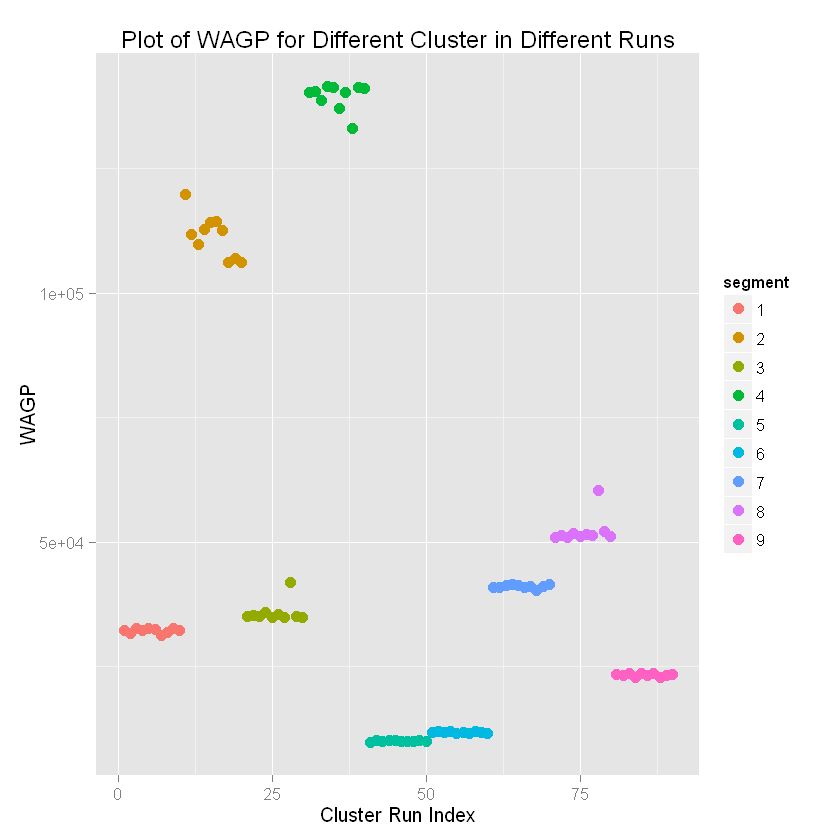

In [116]:
ggplot(output2, aes(x = index, y = WAGP, colour = segment)) + xlab("Cluster Run Index") + 
  geom_point(size = 3) + ggtitle("Plot of WAGP for Different Cluster in Different Runs")

So we see from the 4-cluster that picking a small and sensible k from the dendrogram does not yield the same results every time. In fact our 9-cluster result was far more stable (mean 0.94 Rand Index compared to 0.804). 

### A Framework for Testing

So now we've seen failures and successes and more importantly we have a new set of tools at our disposal in order to assess how often we get similarly interpretable results from our method. So what did we originally want?

1) We want our work to be reproducible in the same dataset.

This framework has provided us with several tools that allows us to evaluate the reproducibility of results (most significantly the Rand Index). Over several runs a mean Rand Index of at least 0.8 indicates that the majority of the time (around 70% - 80% depending on your data) there exists an identical interpretation of the clusters, though without at least a 0.9 Rand Index we suggest cautioning that there may be alternative descriptions of the data.

2) We want stronger way to evaluate k. 

Fundamentally stability and traditional methods for picking k go hand in hand. While originally we wanted to pick k in order to find a good fit of our model to the dataset, we also want to have reliability. We want to find that 'good' model over and over again. At first we wanted 4 groups and now we see that 9 may lead to far more stable results. And it is not always clear that more or less clusters will be more or less stable. If you run this yourself you'll find that k=5 is pretty unstable as well as k=10.

One could automate this process and grid-search the space for a viable stable numbers of segments. With these results we could narrow our search from all possible k's to a handful of stable ones which fit the data well.

3) We want our segments to be interpretable and actionable.

There's still some 'art' here. Can we effectively action and interpret on 9 separate groups? That depends on the work you plan to do with this data. However, with this approach we now know that a 9 segment approach is stable and while we haven't shown it, others (5 and 10) are not. With this knowledge we can make better calls for the right number of clusters.

### Closing Thoughts

Though this framework gives us a greater confidence over our results, there are still aspects that we feel should be covered in future research. Such as:

1) Extension across different clustering methods (should work across a diverse number of unsupervised methods).

We've found a good deal of value in considering stability in our k-mean clustering method and evaluating the quality of our approach. How much of this work can be extended to other methods? In comparing an idealized version of K-means to results from actual datasets Luxburg 2010 remains convinced that stability can be generally extendable to other algorithms, but they point out 'Whether this principle can be proved to work well for algorithms very different from K-means is an open question.'

2) Initialization. 

In our methodology we always led with the belief that out initial segmentation was correct. For stable K's this is mostly likely correct. However, the less stable a K the less likely that we'll correctly guess the most common segmentation the first time. In our 4-cluster scenario we lucked into the right initial segmentation only 70% of the time. In practice we re-run the whole process several times looking for the highest Rand Index (indicating that we lucked into the right initial clustering) and inspecting individual runs for patterns.

There is more than likely a better approach done by not picking an initial segmentation at all and simply storing and comparing the segmentation results. That is perhaps for a future blog post!

3) Stability criterion. 

Right now we consider similar mean Rand Indices as a strong metric for Stability, however several metrics are still up for debate in Academic circles including: Rand index, Jaccard index, Hamming distance, minimal matching distance and Variation of Information distance (Meila 2003).

4) Thanks for coming along and good luck picking your K's! I hope to delve into this a bit more with a future blog post and if you have any questions about the method, feel free to contact us!